In [50]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal

In [51]:
def get_k_clusters(k_value, break_count, centroids):
    
    size_of_label_list = adjusted_matrix.shape[0]
    label_list = [-1 for i in range(size_of_label_list)]
    label_list = np.asarray(label_list)
    
    centroids_old = np.ones(centroids.shape) * -1
    centroids_points_indices_dict = dict()

    iterations = 0
    centroids_equal =False
    center_list = []
    while (centroids_equal == False) and (break_count > 0):
        for i in range(0, size_of_label_list):
            norm_in = centroids - adjusted_matrix[i]
            norm_result = []
            for j in range(norm_in.shape[0]):
                total_sum = 0
                square_root = 0
                temp = []
                temp = norm_in[j]
                for k in range(len(temp)):
                    temp[k] =  temp[k] * temp[k]
                total_sum = sum(temp)
                square_root = np.sqrt(total_sum)
                norm_result.append(square_root)
            label_list[i] = np.argmin(norm_result)
        
        np.copyto(centroids_old, centroids)
        
        for x in range(0, k_value):
            centroids[x, :] = np.mean(adjusted_matrix[np.where(label_list == x)], axis=0)
            centroids_points_indices_dict[x] = np.asarray(np.where(label_list == x)) + 1

        centroids_equal = np.array_equal(centroids, centroids_old)
        iterations = iterations + 1
        break_count = break_count - 1

    center_list = centroids 
    return [label_list, center_list]

In [63]:
def create_clu_dict(mat,clu_dict):
    obj = enumerate(mat)
    for i,r in obj:
        m_val = float('-inf')
        clu = None
        r_en = enumerate(r)
        for j,c in r_en:
            if c>m_val:
                m_val = c
                clu = j+1
        if clu not in clu_dict:
            clu_dict[clu]=[]
        clu_dict[clu].append(data[i])
    return clu_dict

In [53]:
def k_means(k_value, break_count, centroids):
    label_list, center_list = get_k_clusters(k_value, break_count, centroids)
    return [label_list, center_list]

In [54]:
def calculate_likelyhood(data, k, centroids, max_iter):
    likelyhood = []
    adjusted_matrix = data[:, 2:]
    feature_length = len(adjusted_matrix[0])
    temp_matrix = np.identity(feature_length)
    sigma = 0.00001 * temp_matrix
    
    final_s = np.zeros((k,feature_length,feature_length),dtype='float')
    s_len = len(final_s)
    for i in range(s_len):
        np.fill_diagonal(final_s[i], 1)
        
    prob = [1 for i in range(k)]
    for i in range(len(prob)):
        prob[i] = prob[i] / k
    
    for i in range(max_iter):
        mat = np.zeros((data.shape[0], k))
        
        for m,s,p,i in zip(centroids, final_s, prob, range(k)):
            s = s + sigma
            multi_normal = multivariate_normal(mean=m, cov=s, allow_singular=True)
            num = p * multi_normal.pdf(adjusted_matrix)
            mat[:,i] = num / np.sum([clu_p * multivariate_normal(mean=clu_m,cov=clu_c, allow_singular=True).pdf(adjusted_matrix) for clu_p,clu_m,clu_c in zip(prob,centroids,final_s+sigma)],axis=0)

        centroids = []
        final_s = []
        prob = []
        
        for x in range(len(mat[0])):
            mat_c = np.sum(mat[:,x], axis=0)
            mat_x = data[:, 2:] * mat[:, x].reshape(len(data), 1)
            matu_c = (1/mat_c) * np.sum(mat_x, axis=0)
            centroids.append(matu_c)
            a = ((1 / mat_c) * np.dot((np.array(mat[:,x]).reshape(len(data), 1)*(data[:, 2:]-matu_c)).T,(data[:, 2:]-matu_c)))+sigma
            final_s.append(a)
            b = mat_c / np.sum(mat)
            prob.append(b)

        zz = [k*multivariate_normal(mean=centroids[i],cov=final_s[j], allow_singular=True).pdf(data[:, 2:]) for i,j in zip(range(len(centroids)),range(len(final_s)))]
        zz_sum = np.sum(zz)
        like_hood = np.log(zz_sum)
        likelyhood.append(like_hood)
    return mat

In [55]:
def Sort(sub_li): 
    sub_li.sort(key = (lambda x: x[0]))
    return sub_li

In [65]:
def create_label(clu_dict):
    label = None
    for k, v in clu_dict.items():
        for r in v:
            r[1] = k

        if label is not None:
            label = np.concatenate((label, v[:,0: 2]), axis=0)
        else:
            label = v[:,0: 2]
    return label

In [66]:
def compute_similarity_coeff(label, ground_truth):
    m11=0
    m10=0
    m01=0
    m00=0
    for i in range(0,len(ground_truth)):
        first_ground_truth = ground_truth[i];
        first_cluster_value = label[i];
        
        for j in range(1,len(ground_truth)):
            second_ground_truth = ground_truth[j]
            second_cluster_value = label[j]
            ground_truth_value = (first_ground_truth == second_ground_truth)
            cluster_similarity_value = (first_cluster_value == second_cluster_value)
            
            if(ground_truth_value==True and cluster_similarity_value==True):
                m11 +=1
            elif(ground_truth_value==True and cluster_similarity_value==False):
                m10 +=1
            elif(ground_truth_value==False and cluster_similarity_value==True):
                m01 +=1
            elif(ground_truth_value==False and cluster_similarity_value==False):
                m00 +=1
    
    jacard=float(m11/(m11+m01+m10))
    print("Jaccard Coefficient: ", jacard)
    rand=float((m11+m00)/(m11+m00+m10+m01))
    print("Rand Index: ", rand)

In [67]:
def reshape_clu_dict(clu_dict):
    for k,v in clu_dict.items():
        clu_dict[k] = np.array(v, dtype=np.float64)
    return clu_dict

In [68]:
def plot_PCA(file, labels, plot_title):
    file = open(file, 'r');
    gene_data = file.readlines();
    gene_row_len = len(gene_data[0].split('\t'))
    gene_data_matrix = [[np.float64(x) for x in line.split('\t')] for line in gene_data]
    gene_data_matrix = np.asarray(gene_data_matrix, dtype=float)
    data = gene_data_matrix[:, 2:gene_row_len]
    pca = PCA(n_components=2)
    principalComp = pca.fit_transform(data)
    pca_df = pd.DataFrame(data=principalComp, columns=['PC1', 'PC2'])
    pca_df["label"] = labels
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel('PC1', fontsize=15)
    ax.set_ylabel('PC2', fontsize=15)
    ax.set_title('2 component PCA', fontsize=20)
    unique_list = []
    for x in labels:
        if x not in unique_list:
            unique_list.append(x)
    colors = ['r', 'g', 'b']
    for target, color in zip(unique_list, colors):
        indicesToKeep = pca_df['label'] == target
        ax.scatter(pca_df.loc[indicesToKeep, 'PC1']
                   , pca_df.loc[indicesToKeep, 'PC2']
                   , c=color
                   , s=50)
    ax.legend(unique_list)
    ax.set_title(plot_title)
    ax.grid()
    plt.show()

In [69]:
def perform_gmm(data, k, centroids, max_iter):
    clu_dict = dict()
    mat = calculate_likelyhood(data, k, centroids, max_iter)
    clu_dict = create_clu_dict(mat,clu_dict)
    clu_dict = reshape_clu_dict(clu_dict)
    label = create_label(clu_dict)
    label = label.tolist()
    label = Sort(label)
    label = [[round(x) for x in y] for y in label]
    label_list = []
    for i in label:
        label_list.append(i[1])
    return label_list

Enter datafile name with extension: iyer.txt
Enter Maximum Number of iterations: 100
Enter number of initial centroids: 3
Enter Centroid: 3
Enter Centroid: 5
Enter Centroid: 9
[3, 5, 9]
Jaccard Coefficient:  0.2840210008871566
Rand Index:  0.6309207862894157


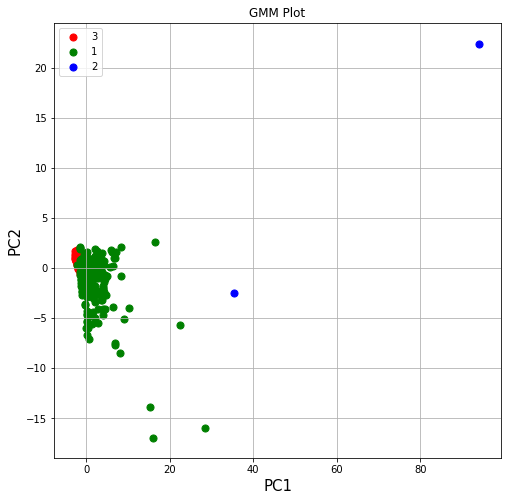

In [71]:
file = input('Enter datafile name with extension: ')
max_iterations = int(input('Enter Maximum Number of iterations: '))
c = []
number_initial_centroids = int(input('Enter number of initial centroids: '))
for i in range(0, number_initial_centroids): 
    ele = int(input('Enter Centroid: ')) 
  
    c.append(ele) # adding the element 
      
print(c) 

data = np.loadtxt(file, dtype='float')
adjusted_matrix = data[:, 2:]
initial_centroid_indices = [int(centroid_index) - 1 for centroid_index in c]
k = len(initial_centroid_indices)
centroids = adjusted_matrix[initial_centroid_indices, :]
cluster_id_list, centroids = k_means(k, max_iterations, centroids)
label_list = perform_gmm(data, k, centroids, max_iterations)
ground_truth = [item[1] for item in data]
compute_similarity_coeff(label_list, ground_truth)
plot_PCA(file, label_list, "GMM Plot")